# Test

Statistiken/Daten:
https://data.oecd.org/ict/internet-access.htm
https://data.oecd.org/hha/household-spending.htm
https://data.oecd.org/broadband/households-with-broadband-access.htm
https://data.oecd.org/eduresource/private-spending-on-education.htm
https://data.oecd.org/eduresource/public-spending-on-education.htm
https://en.wikipedia.org/wiki/List_of_countries_by_number_of_households

Korrelationsmatrix um Märkte zu identifizieren die Deutschland ähnlich sind:

U.a. Normalisierung undabhängiger Variablen (5.)
https://towardsdatascience.com/7-steps-to-run-a-linear-regression-analysis-using-r-d5897a66b835

Linear Regression Model Accurancy
http://www.sthda.com/english/articles/40-regression-analysis/167-simple-linear-regression-in-r/

Correlation Matrix
https://www.displayr.com/how-to-create-a-correlation-matrix-in-r/

Idee 1 - vergleichbare Märkte finden:
Deutschland als Erfolgreicher Mark etabliert, ähnliche Märkte sollen gefunden werden.
Zunächst werden die Faktoren, Parameter bestimmt die für Erfolg/Nicht Erfolg verantwortlich sind.
Faktoren: Internetzugriff, Bildungsausgaben, usw -> Korrelationsmatrix (3D) mit Deutschland als Mittelwert 
                                                                                   andere Länder werden damit verglichen (Varianzanalyse)
                                                                                   wenn Werte zu 95% darin liegen (Nullhypothese, Konfidenzintervall)
Ergebnis: Liste mit 10 Kandidaten (Varianz(-bereich))

Idee 2 - Preisberechnung:
Ausgehen vom Preis in Deutschland von 12€/a wird der Anteil der Haushaltsausgaben in Prozent berechnet:
PercentageApp = AppPrice/((Houshold spendings*ExchangeFactor$€)/(Houshold number))
-> 0,00025%
Für alle 10 Kandidaten nun  AppPrice=0,00025%*(Houshold spendings)

In [1]:
library(tidyverse)
library(httr)
library(XML)
library(stringr)

── Attaching packages ────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Download Dataset from OECD website and store them in data frames

In [2]:
df_internet_access <- read.csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.INTERNET.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en", header=TRUE)
df_household_spendings <- read.csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HHEXP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en", header=TRUE)

url <- "https://www.iban.com/country-codes"
r <- GET(url)
doc <- readHTMLTable(doc=content(r, "text"))
df_country_codes <- doc[[1]]
names(df_country_codes)[3] <- "LOCATION"
df_country_codes <- subset(df_country_codes, select=c(Country,LOCATION))

df_internet_access <- merge(df_internet_access, df_country_codes,by=c("LOCATION"))
df_household_spendings <- merge(df_household_spendings, df_country_codes,by=c("LOCATION"))

In [3]:
head(df_internet_access)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag.Codes,Country
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>
1,AUS,INTERNET,TOT,PC_HH,A,2005,60.00,D,Australia
2,AUS,INTERNET,TOT,PC_HH,A,2006,64.00,D,Australia
3,AUS,INTERNET,TOT,PC_HH,A,2007,67.00,D,Australia
4,AUS,INTERNET,TOT,PC_HH,A,2008,72.00,D,Australia
5,AUS,INTERNET,TOT,PC_HH,A,2010,78.92,D,Australia
6,AUS,INTERNET,TOT,PC_HH,A,2012,83.00,D,Australia


In [4]:
head(df_household_spendings)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag.Codes,Country
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>
1,AUS,HHEXP,TOT,AGRWTH,A,2011,2.857574e+00,,Australia
2,AUS,HHEXP,HOUSING,PC_DI,A,1980,1.336414e+01,,Australia
3,AUS,HHEXP,TOT,MLN_USD,A,1982,1.058935e+05,,Australia
4,AUS,HHEXP,TOT,MLN_USD,A,1981,9.759836e+04,,Australia
5,AUS,HHEXP,TOT,MLN_USD,A,1975,5.249257e+04,,Australia
6,AUS,HHEXP,TOT,MLN_USD,A,1976,5.697552e+04,,Australia


# Normalize and display Internet Access data set

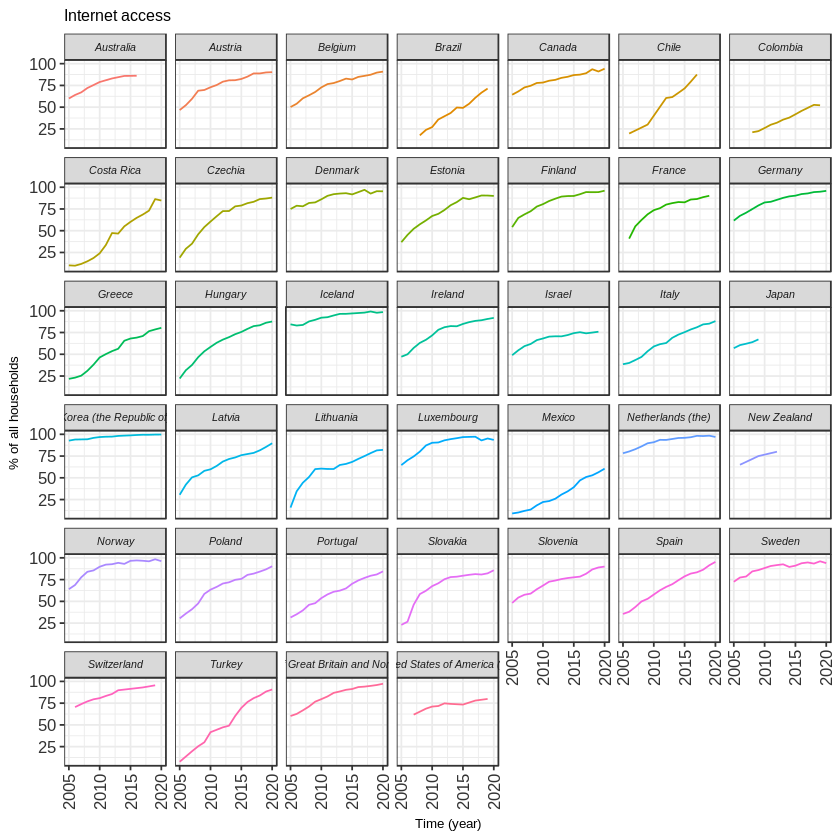

In [5]:
df_internet_access <- df_internet_access[lapply(df_internet_access,length)>0]

#Normalization needed?
#df_internet_access$Value <- (df_internet_access$Value - mean(df_internet_access$Value)) / sd(df_internet_access$Value)

ggplot(data = df_internet_access, mapping = aes(x = TIME, y = Value, color = Country)) +
    geom_line() +
    facet_wrap(vars(Country)) +
    labs(title = "Internet access",
        x = "Time (year)",
        y = "% of all households") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")


# Normalize and display Household Spendings dataset

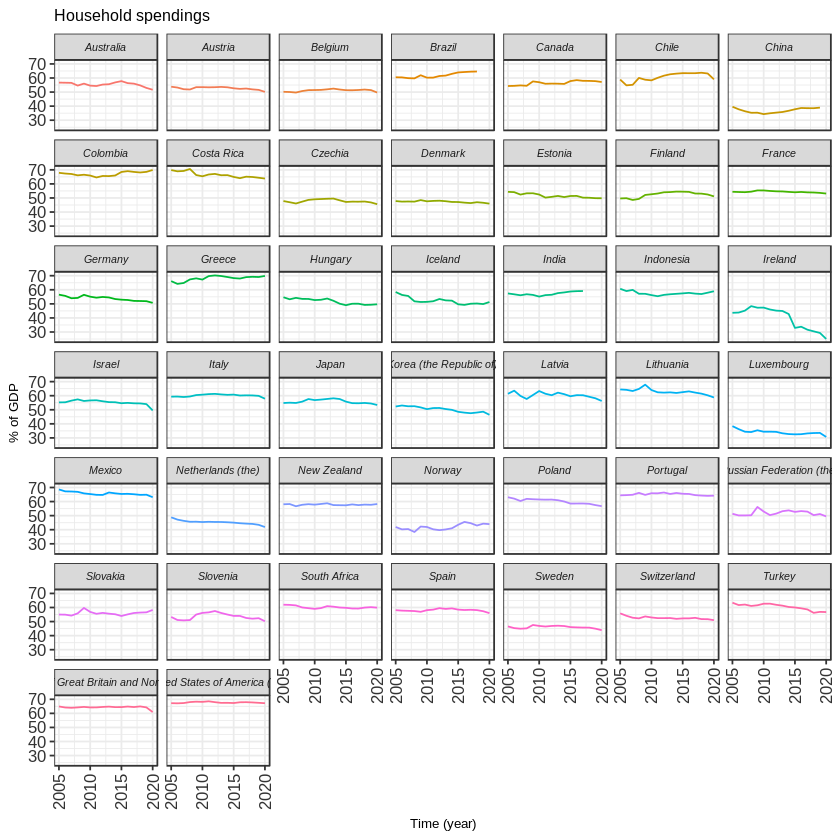

In [6]:
df_household_spendings <- df_household_spendings[lapply(df_household_spendings,length)>0]

df_household_spendings.pcgdp <- df_household_spendings
df_household_spendings.pcgdp <- subset(df_household_spendings.pcgdp, MEASURE == 'PC_GDP')
df_household_spendings.pcgdp <- subset(df_household_spendings.pcgdp, SUBJECT == 'TOT')
df_household_spendings.pcgdp <- subset(df_household_spendings.pcgdp, TIME >= 2005)
df_household_spendings.pcgdp <- subset(df_household_spendings.pcgdp, LOCATION != 'EU' & LOCATION != 'EA')
#Normalization needed?
#df_household_spendings$Value <- log(df_household_spendings$Value)
#df_household_spendings$Value <- (df_household_spendings$Value - min(df_household_spendings$Value)) /(max(df_household_spendings$Value)-min(df_household_spendings$Value))

ggplot(data = df_household_spendings.pcgdp, mapping = aes(x = TIME, y = Value, color = Country)) +
    geom_line() +
    facet_wrap(vars(Country)) +
    labs(title = "Household spendings",
        x = "Time (year)",
        y = "% of GDP") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")

### Normalize spending per inhabitant

In [7]:
url <- "https://en.wikipedia.org/wiki/List_of_countries_by_number_of_households"
r <- GET(url)
doc <- readHTMLTable(doc=content(r, "text"))
df_household_numbers <- doc[[2]]
df_household_numbers <- setNames(df_household_numbers, c("Country", "Continent", "Current Population", "NumberInHousehold", 
                                    "Households", "1Member", "2_3Members", "4_5Members", "6Members", "TIME"))

df_household_numbers$TIME <- str_replace_all(df_household_numbers$TIME, "\\[2\\]", "")
df_household_numbers$TIME <- as.integer(df_household_numbers$TIME) 
df_household_numbers <- na.omit(df_household_numbers)
df_household_numbers$Country <- sub("\\W+", "", df_household_numbers$Country)

df_household_numbers <- merge(df_household_numbers, df_country_codes,by="Country")
head(df_household_numbers)

df_household_spendings <- read.csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HHEXP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en", header=TRUE)
df_household_spendings.mlnusd <- subset(df_household_spendings, MEASURE == 'MLN_USD')
df_household_spendings.mlnusd <- na.omit(df_household_spendings.mlnusd)
head(df_household_spendings.mlnusd)

#df_spending_per_household <- merge(df_household_numbers, df_household_spendings.mlnusd, by=c("LOCATION", "TIME"))
df_spending_per_household <- merge(df_household_numbers, df_household_spendings.mlnusd, by=c("LOCATION"))

df_spending_per_household$Households <- str_replace_all(df_spending_per_household$Households, ",", "")
df_spending_per_household$Households <- as.double(df_spending_per_household$Households)

df_spending_per_household$NumberInHousehold <- str_replace_all(df_spending_per_household$NumberInHousehold, ",", ".")
df_spending_per_household$NumberInHousehold <- as.double(df_spending_per_household$NumberInHousehold)

df_spending_per_household$HouseholdSpending <- with(df_spending_per_household, 
                                                    df_spending_per_household$Value*1000000/df_spending_per_household$Households)

df_spending_per_household$PerPersonSpending <- with(df_spending_per_household, 
                                                    df_spending_per_household$HouseholdSpending / df_spending_per_household$NumberInHousehold)
head(df_spending_per_household)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


,Country,Continent,Current Population,NumberInHousehold,Households,1Member,2_3Members,4_5Members,6Members,TIME,LOCATION
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>
1,Afghanistan,Asia,"32,890,171",8.04,"4,092,477",0.19,6.45,16.84,76.52,2015,AFG
2,Albania,Europe,"2,845,955",3.3,"862,512",9.95,48.08,32.51,9.45,2017,ALB
3,Angola,Africa,"31,127,674",4.82,"6,463,847",10.81,23.90,28.46,36.83,2016,AGO
4,Argentina,South America,"45,376,763",3.26,"13,925,275",17.6,42.33,28.95,11.12,2010,ARG
5,Armenia,Asia,"2,967,900",3.54,"837,896",15.19,36.17,32.30,16.34,2016,ARM
6,Aruba,Caribbean,"112,269",2.89,"38,855",21.37,46.77,25.59,6.28,2010,ABW


,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag.Codes
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>
1,AUS,HHEXP,TOT,MLN_USD,A,1970,30516.70,
2,AUS,HHEXP,TOT,MLN_USD,A,1971,32843.32,
3,AUS,HHEXP,TOT,MLN_USD,A,1972,35636.84,
4,AUS,HHEXP,TOT,MLN_USD,A,1973,41167.69,
5,AUS,HHEXP,TOT,MLN_USD,A,1974,48525.00,
6,AUS,HHEXP,TOT,MLN_USD,A,1975,52492.57,


,LOCATION,Country,Continent,Current Population,NumberInHousehold,Households,1Member,2_3Members,4_5Members,6Members,TIME.x,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME.y,Value,Flag.Codes,HouseholdSpending,PerPersonSpending
,<fct>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>
1,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,1980,84721.43,,8289.617,3315.847
2,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,2019,675649.10,,66109.277,26443.711
3,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,1979,74438.63,,7283.491,2913.396
4,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,2018,686380.02,,67159.249,26863.700
5,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,1991,179023.39,,17516.647,7006.659
6,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,1984,114651.71,,11218.163,4487.265


# Perform linear regression and predict Houshold Spendings for 2021 and 2022


Call:
lm(formula = PerPersonSpending ~ TIME.y + LOCATION, data = df_spending_per_household)

Residuals:
    Min      1Q  Median      3Q     Max 
-6762.8 -1118.9  -318.9   923.7 10494.1 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -8.708e+05  8.023e+03 -108.532  < 2e-16 ***
TIME.y       4.421e+02  4.019e+00  109.983  < 2e-16 ***
LOCATIONAUT  1.464e+03  3.975e+02    3.684 0.000239 ***
LOCATIONBEL  3.752e+01  3.975e+02    0.094 0.924814    
LOCATIONBRA -1.056e+04  4.990e+02  -21.162  < 2e-16 ***
LOCATIONCAN  2.552e+02  3.975e+02    0.642 0.520988    
LOCATIONCHE  4.148e+03  3.975e+02   10.435  < 2e-16 ***
LOCATIONCHL -8.830e+03  4.802e+02  -18.389  < 2e-16 ***
LOCATIONCHN -1.311e+04  4.634e+02  -28.282  < 2e-16 ***
LOCATIONCOL -1.098e+04  4.863e+02  -22.574  < 2e-16 ***
LOCATIONCRI -9.125e+03  4.638e+02  -19.675  < 2e-16 ***
LOCATIONDEU  1.917e+03  3.975e+02    4.823 1.57e-06 ***
LOCATIONESP -1.606e+03  3.975e+02   -4.040 5.64e-05 ***
LOCATIONEST -7

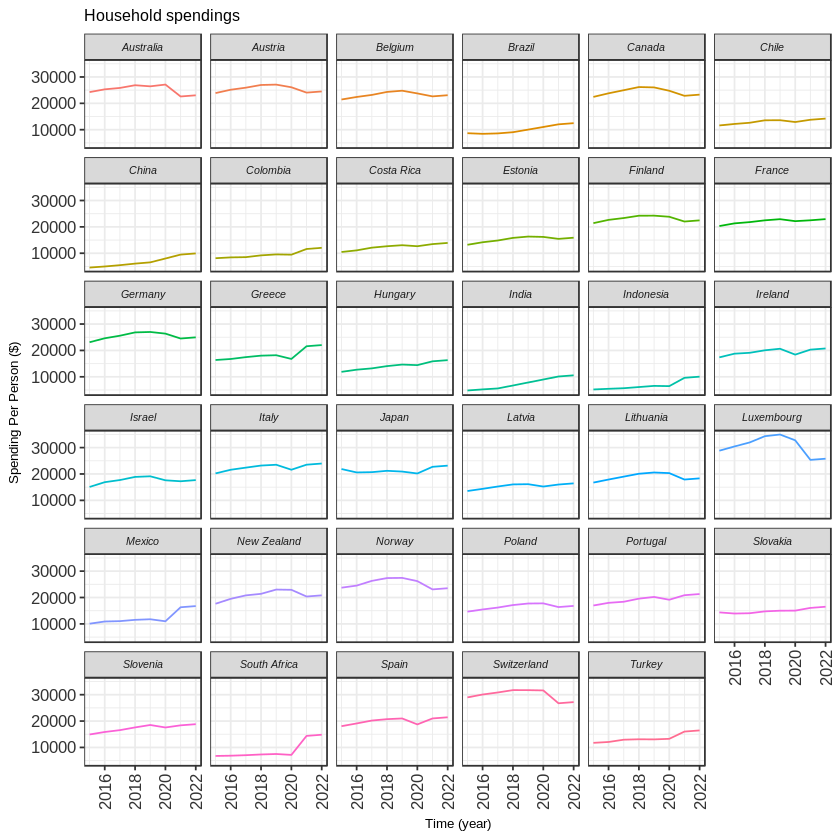

In [8]:
model = lm(PerPersonSpending ~ TIME.y + LOCATION, data = df_spending_per_household) #Create the linear regression
summary(model) #Review the results

df_hs <- df_spending_per_household[c("LOCATION", "Country", "TIME.y", "PerPersonSpending")]

LOCATION <- unique(df_hs$LOCATION, incomparables = FALSE)

df_2021 <- data.frame(LOCATION, Country='', TIME.y=2021, PerPersonSpending='')
df_2021$PerPersonSpending <- predict(model, df_2021)
df_hs <- rbind(df_hs, df_2021)

df_2022 <- data.frame(LOCATION, Country='', TIME.y=2022, PerPersonSpending='')
df_2022$PerPersonSpending <- predict(model, df_2022)
df_hs <- rbind(df_hs, df_2022)

df_hs <- merge(df_hs, df_country_codes,by=c("LOCATION"))
#df_hs

df_hs <- subset(df_hs, TIME.y >= 2015)

ggplot(data = df_hs, mapping = aes(x = TIME.y, y = PerPersonSpending, color = Country.y)) +
    geom_line() +
    facet_wrap(vars(Country.y)) +
    labs(title = "Household spendings",
        x = "Time (year)",
        y = "Spending Per Person ($)") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")

## Perform linear regression and predict Internet Access for 2021 and 2022


Call:
lm(formula = Value ~ TIME + LOCATION, data = df_internet_access)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.936  -3.631   1.156   4.639  22.957 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.807e+03  1.362e+02 -42.651  < 2e-16 ***
TIME         2.927e+00  6.774e-02  43.207  < 2e-16 ***
LOCATIONAUT -6.915e+00  3.094e+00  -2.235 0.025868 *  
LOCATIONBEL -7.314e+00  3.094e+00  -2.363 0.018474 *  
LOCATIONBRA -4.068e+01  3.266e+00 -12.458  < 2e-16 ***
LOCATIONCAN -8.947e-01  3.094e+00  -0.289 0.772587    
LOCATIONCHE  3.973e+00  3.317e+00   1.198 0.231545    
LOCATIONCHL -2.380e+01  3.572e+00  -6.663 6.91e-11 ***
LOCATIONCOL -4.851e+01  3.323e+00 -14.599  < 2e-16 ***
LOCATIONCRI -3.831e+01  3.094e+00 -12.379  < 2e-16 ***
LOCATIONCZE -1.772e+01  3.094e+00  -5.728 1.73e-08 ***
LOCATIONDEU  1.220e+00  3.094e+00   0.394 0.693673    
LOCATIONDNK  5.873e+00  3.094e+00   1.898 0.058263 .  
LOCATIONESP -1.590e+01  3.094e+00  -5.137 3.96e-0

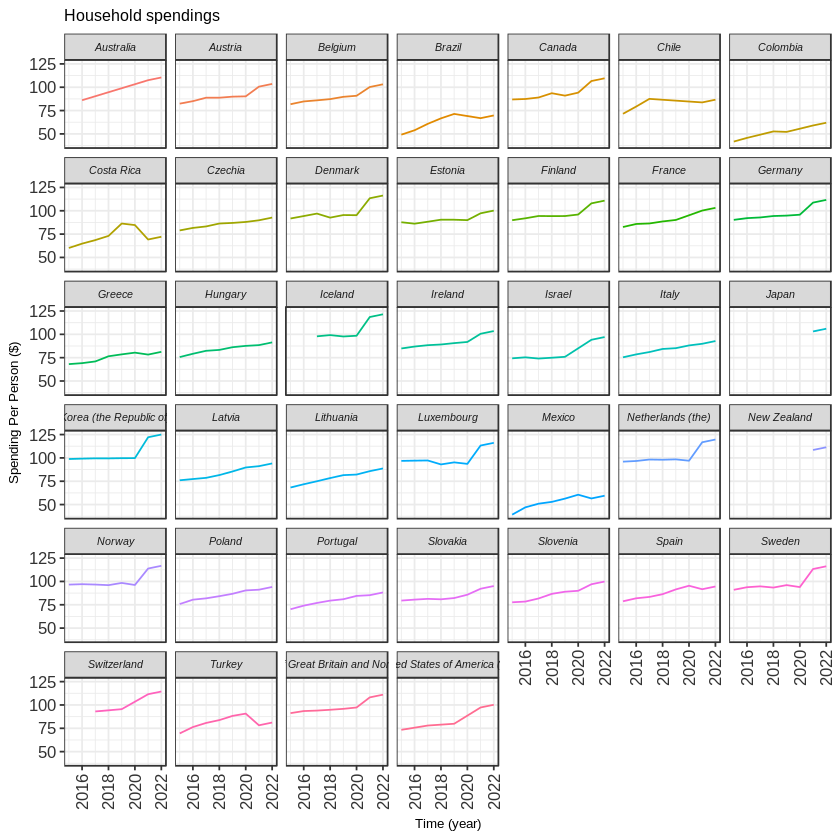

In [9]:
model = lm(Value ~ TIME + LOCATION, data = df_internet_access) #Create the linear regression
summary(model) #Review the results

df_ia <- df_internet_access[c("LOCATION", "Country", "TIME", "Value")]

LOCATION <- unique(df_ia$LOCATION, incomparables = FALSE)

df_ia2021 <- data.frame(LOCATION, Country='', TIME=2021, Value='')
df_ia2021$Value <- predict(model, df_ia2021)
df_ia <- rbind(df_ia, df_ia2021)

df_ia2022 <- data.frame(LOCATION, Country='', TIME=2022, Value='')
df_ia2022$Value <- predict(model, df_ia2022)
df_ia <- rbind(df_ia, df_ia2022)

df_ia <- merge(df_ia, df_country_codes,by=c("LOCATION"))

df_ia <- subset(df_ia, TIME >= 2015)

ggplot(data = df_ia, mapping = aes(x = TIME, y = Value, color = Country.y)) +
    geom_line() +
    facet_wrap(vars(Country.y)) +
    labs(title = "Household spendings",
        x = "Time (year)",
        y = "Spending Per Person ($)") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")


# Correlation between Household Spendings (% of GDP) and Internet Access (% of all households)

,LOCATION,CORR
,<fct>,<dbl>
10,DEU,-0.08888715


,LOCATION,CORR
,<fct>,<dbl>
9,CRI,0.58427251
24,MEX,0.56831081
11,ESP,0.52804843
12,EST,0.49196451
21,LTU,0.38321198
31,TUR,0.16901697
3,BEL,0.14280649
18,ISR,0.01189632
13,FIN,-0.24168859


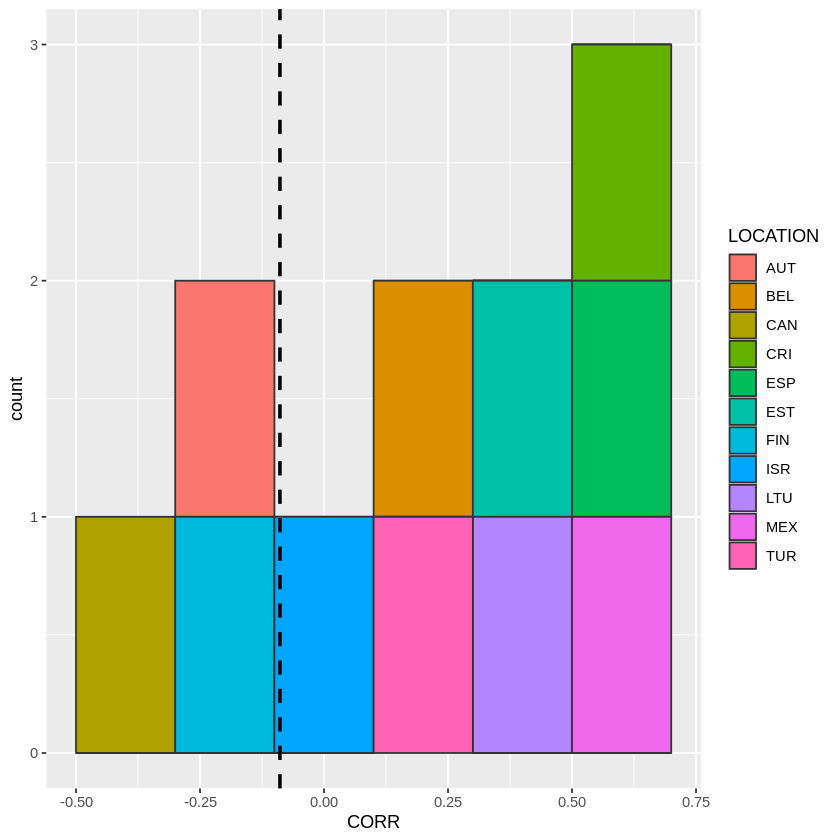

In [19]:
names(df_hs)[3] <- "TIME"
#head(df_hs)
#head(df_ia)
df <- merge(df_hs, df_ia,by=c("LOCATION","TIME"))
xx <- data.frame(group = df$LOCATION, a = df$PerPersonSpending , b = df$Value )

# This returns a "by" object
result <- by(xx[,2:3], xx$group, function(x) {cor(x$a, x$b)})

# You get pretty close to what you want if you coerce it into a data frame via a matrix
result.dataframe <- as.data.frame(as.matrix(result))
result.dataframe <- na.omit(result.dataframe)
result.dataframe <- cbind(newColName = rownames(result.dataframe), result.dataframe)
rownames(result.dataframe) <- 1:nrow(result.dataframe)

colnames(result.dataframe) <- c("LOCATION","CORR")
result.dataframe <- result.dataframe[order(result.dataframe$CORR,decreasing=TRUE), ]

germany <- result.dataframe[result.dataframe$LOCATION == 'DEU', ]
germany

result.dataframe <- result.dataframe[result.dataframe$CORR <= 0.6 & result.dataframe$CORR >= -0.6 & result.dataframe$LOCATION != 'DEU', ]
result.dataframe

ggplot(aes(x = CORR ), data = result.dataframe) + 
  geom_histogram(aes(fill = LOCATION ), binwidth=0.2, colour="grey20") +
  geom_vline(aes(xintercept=germany$CORR), color="black", linetype="dashed", size=1)


## correlation coefficients for a set of variables used to determine if a relationship exists between the variables. The coefficient indicates both the strength of the relationship as well as the direction (positive vs. negative correlations)

In [11]:
df_germany <- subset(df_hs, LOCATION == 'DEU' & TIME == 2020)
#df_germany

url <- "https://www.xe.com/currencyconverter/convert/?Amount=1&From=EUR&To=USD"
r <- GET(url)
doc <- readHTMLTable(doc=content(r, "text"))

xe <- doc[[1]]
xe <- xe[1,]

xe.dollar <- str_replace_all(xe$USD, "USD", "")
xe.dollar <- as.double(xe.dollar)
#xe.dollar

app.price.eur <- 12
app.price.dollar <- app.price.eur * xe.dollar
app.percentage.spending <- (app.price.dollar)/(df_germany$PerPersonSpending)
app.percentage.spending 

[1] 0.0005151723

In [23]:
df_final <- merge(result.dataframe, df_hs, by=c("LOCATION"))

df_final <- subset(df_hs, TIME == 2022)
df_final$AppPrice <- with(df_final, df_final$PerPersonSpending*app.percentage.spending )

df_final <- df_final[c("Country.y","TIME", "AppPrice")]
df_final

,Country.y,TIME,AppPrice
,<fct>,<dbl>,<dbl>
52,Australia,2022,11.869574
105,Austria,2022,12.623936
157,Belgium,2022,11.888903
185,Brazil,2022,6.429236
230,Canada,2022,12.001042
288,Switzerland,2022,14.006463
319,Chile,2022,7.320624
351,China,2022,5.117292
369,Colombia,2022,6.214021
